In [1]:
import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tqdm
from tqdm import tqdm

In [2]:
data ='/content/sample_data/california_housing_test.csv'
df = pd.read_csv(data)
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-122.05,37.37,27.0,3885.0,661.0,1537.0,606.0,6.6085,344700.0
1,-118.30,34.26,43.0,1510.0,310.0,809.0,277.0,3.5990,176500.0
2,-117.81,33.78,27.0,3589.0,507.0,1484.0,495.0,5.7934,270500.0
3,-118.36,33.82,28.0,67.0,15.0,49.0,11.0,6.1359,330000.0
4,-119.67,36.33,19.0,1241.0,244.0,850.0,237.0,2.9375,81700.0


In [3]:
df.skew()
max_value = df['median_house_value'].max()
min_value = df['median_house_value'].min()

In [4]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,3000.000000,3000.00000,3000.000000,3000.000000,3000.000000,3000.000000,3000.00000,3000.000000,3000.00000
mean,-119.589200,35.63539,28.845333,2599.578667,529.950667,1402.798667,489.91200,3.807272,205846.27500
std,1.994936,2.12967,12.555396,2155.593332,415.654368,1030.543012,365.42271,1.854512,113119.68747
min,-124.180000,32.56000,1.000000,6.000000,2.000000,5.000000,2.00000,0.499900,22500.00000
25%,-121.810000,33.93000,18.000000,1401.000000,291.000000,780.000000,273.00000,2.544000,121200.00000
50%,-118.485000,34.27000,29.000000,2106.000000,437.000000,1155.000000,409.50000,3.487150,177650.00000
75%,-118.020000,37.69000,37.000000,3129.000000,636.000000,1742.750000,597.25000,4.656475,263975.00000
max,-114.490000,41.92000,52.000000,30450.000000,5419.000000,11935.000000,4930.00000,15.000100,500001.00000


In [5]:
df.shape[1]

9

<Axes: xlabel='median_house_value', ylabel='Count'>

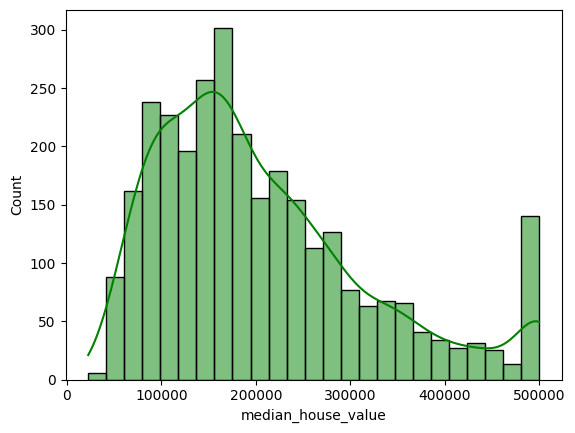

In [6]:
sns.histplot(data=df, x="median_house_value", color='g', kde=True)

In [7]:
columns_to_log = ['total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']
df[columns_to_log] = df[columns_to_log].apply(np.log1p)

In [8]:
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)
df_scaled.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,0.219814,0.513889,0.509804,0.754267,0.719627,0.730227,0.717102,0.685988,0.674763
1,0.606811,0.181624,0.823529,0.641518,0.618887,0.645809,0.611641,0.473320,0.322512
2,0.657379,0.130342,0.509804,0.744811,0.684319,0.725610,0.689829,0.638119,0.519371
3,0.600619,0.134615,0.529412,0.271378,0.223220,0.279145,0.187219,0.658898,0.643978
4,0.465428,0.402778,0.352941,0.618118,0.587079,0.652310,0.590661,0.407718,0.123979


In [9]:
df_train, df_test = train_test_split(df_scaled, test_size=0.2, random_state=42)

In [10]:
class HousingDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe
        self.features = torch.tensor(dataframe.drop(columns=['median_house_value', 'longitude', 'latitude']).values, dtype=torch.float32)
        self.label = torch.tensor(dataframe['median_house_value'].values, dtype=torch.float32)

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        features = self.features[idx]
        target = self.label[idx]
        return features, target

In [11]:
class HousingModel(nn.Module):
    def __init__(self, input_size, fc_1, fc_2, output_size):
        super(HousingModel, self).__init__()
        self.input_size = input_size
        self.fc_1= fc_1
        self.fc_2= fc_2
        self.output_size = output_size
        self.LinearRegression = nn.Sequential(
            nn.Linear(self.input_size, self.fc_1),
            nn.ReLU(),
            nn.Linear(self.fc_1, self.fc_2),
            nn.ReLU(),
            nn.Linear(self.fc_2, output_size)
        )

    def forward(self, x):
        logits = self.LinearRegression(x)
        return logits

In [12]:
#hyperparamter
input_size = df_train.shape[1] - 3
fc_1 = 32
fc_2 = 32
output_size = 1
model = HousingModel(input_size, fc_1, fc_2, output_size)
print(model)

HousingModel(
  (LinearRegression): Sequential(
    (0): Linear(in_features=6, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [13]:
train_dataset = HousingDataset(df_train)
test_dataset = HousingDataset(df_test)

In [14]:
for i, (features, target) in enumerate(train_dataset):
    print(features, target)
    if i == 10:
      break

tensor([0.5294, 0.6849, 0.7482, 0.7967, 0.7482, 0.2755]) tensor(0.4111)
tensor([0.4510, 0.7158, 0.7224, 0.7237, 0.7202, 0.5242]) tensor(0.6006)
tensor([0.5882, 0.6135, 0.6132, 0.7357, 0.6250, 0.3373]) tensor(0.2831)
tensor([0.7255, 0.6364, 0.6114, 0.6791, 0.6150, 0.5201]) tensor(0.3958)
tensor([0.8824, 0.7224, 0.7160, 0.7252, 0.7105, 0.4933]) tensor(0.5259)
tensor([0.0784, 0.8186, 0.8009, 0.8188, 0.7959, 0.4228]) tensor(0.2536)
tensor([0.5098, 0.6712, 0.6920, 0.6989, 0.6862, 0.3871]) tensor(0.1361)
tensor([0.2549, 0.7175, 0.6460, 0.7198, 0.6553, 0.6895]) tensor(0.6052)
tensor([0.7059, 0.6429, 0.6276, 0.7274, 0.6327, 0.4435]) tensor(0.2253)
tensor([0.2549, 0.7242, 0.7160, 0.7387, 0.7117, 0.2207]) tensor(0.1694)
tensor([0.2157, 0.7301, 0.6877, 0.7347, 0.6879, 0.5516]) tensor(0.1648)


In [15]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [16]:
#optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.005)
loss_fn = nn.MSELoss()

In [26]:
EPOCHS = 200
num_epoch = []
training_loss = []
validation_loss = []
target_validation = []

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    num_epoch.append(epoch)

    train_loader_tqdm = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{EPOCHS} - Training")
    for batch_idx, (features, target) in enumerate(train_loader_tqdm):
        optimizer.zero_grad()
        output = model(features)
        loss = loss_fn(output, target.unsqueeze(1))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        train_loader_tqdm.set_postfix(loss=loss.item())

    avg_train_loss = running_loss / len(train_dataloader)
    training_loss.append(avg_train_loss)
    print(f"Epoch {epoch+1} - Training Loss: {avg_train_loss:.4f}")

    model.eval()
    running_val_loss = 0.0

    with torch.no_grad():
        validation_loader_tqdm = tqdm(test_dataloader, desc=f"Epoch {epoch+1}/{EPOCHS} - Validation")
        for vbatch_idx, (vfeatures, vtarget) in enumerate(validation_loader_tqdm):
            voutput = model(vfeatures)
            vloss = loss_fn(voutput, vtarget.unsqueeze(1))
            running_val_loss += vloss.item()

    avg_val_loss = running_val_loss / len(test_dataloader)
    validation_loss.append(avg_val_loss)
    print(f"Epoch {epoch+1} - Validation Loss: {avg_val_loss:.4f}")

Epoch 1/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 210.06it/s, loss=0.0329]


Epoch 1 - Training Loss: 0.0317


Epoch 1/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 709.22it/s]


Epoch 1 - Validation Loss: 0.0279


Epoch 2/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 206.18it/s, loss=0.031]


Epoch 2 - Training Loss: 0.0316


Epoch 2/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 992.48it/s]


Epoch 2 - Validation Loss: 0.0287


Epoch 3/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 213.57it/s, loss=0.0359]


Epoch 3 - Training Loss: 0.0316


Epoch 3/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 1044.11it/s]


Epoch 3 - Validation Loss: 0.0284


Epoch 4/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 229.98it/s, loss=0.0325]


Epoch 4 - Training Loss: 0.0316


Epoch 4/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 704.87it/s]


Epoch 4 - Validation Loss: 0.0280


Epoch 5/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 174.27it/s, loss=0.0353]


Epoch 5 - Training Loss: 0.0315


Epoch 5/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 548.45it/s]


Epoch 5 - Validation Loss: 0.0277


Epoch 6/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 174.69it/s, loss=0.0261]


Epoch 6 - Training Loss: 0.0314


Epoch 6/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 401.24it/s]


Epoch 6 - Validation Loss: 0.0281


Epoch 7/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 185.22it/s, loss=0.0216]


Epoch 7 - Training Loss: 0.0313


Epoch 7/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 591.65it/s]


Epoch 7 - Validation Loss: 0.0292


Epoch 8/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 164.15it/s, loss=0.0349]


Epoch 8 - Training Loss: 0.0314


Epoch 8/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 493.83it/s]


Epoch 8 - Validation Loss: 0.0284


Epoch 9/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 168.66it/s, loss=0.0376]


Epoch 9 - Training Loss: 0.0314


Epoch 9/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 700.38it/s]


Epoch 9 - Validation Loss: 0.0291


Epoch 10/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 173.83it/s, loss=0.0261]


Epoch 10 - Training Loss: 0.0313


Epoch 10/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 538.25it/s]


Epoch 10 - Validation Loss: 0.0272


Epoch 11/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 132.78it/s, loss=0.0365]


Epoch 11 - Training Loss: 0.0314


Epoch 11/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 395.66it/s]


Epoch 11 - Validation Loss: 0.0282


Epoch 12/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 153.17it/s, loss=0.0482]


Epoch 12 - Training Loss: 0.0315


Epoch 12/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 335.91it/s]


Epoch 12 - Validation Loss: 0.0277


Epoch 13/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 119.93it/s, loss=0.029]


Epoch 13 - Training Loss: 0.0312


Epoch 13/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 380.38it/s]


Epoch 13 - Validation Loss: 0.0287


Epoch 14/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 135.69it/s, loss=0.0162]


Epoch 14 - Training Loss: 0.0310


Epoch 14/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 485.33it/s]


Epoch 14 - Validation Loss: 0.0277


Epoch 15/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 141.33it/s, loss=0.0214]


Epoch 15 - Training Loss: 0.0310


Epoch 15/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 471.51it/s]


Epoch 15 - Validation Loss: 0.0276


Epoch 16/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 113.69it/s, loss=0.0292]


Epoch 16 - Training Loss: 0.0311


Epoch 16/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 463.72it/s]


Epoch 16 - Validation Loss: 0.0288


Epoch 17/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 119.16it/s, loss=0.0342]


Epoch 17 - Training Loss: 0.0311


Epoch 17/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 391.77it/s]


Epoch 17 - Validation Loss: 0.0290


Epoch 18/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 115.34it/s, loss=0.0262]


Epoch 18 - Training Loss: 0.0310


Epoch 18/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 407.80it/s]


Epoch 18 - Validation Loss: 0.0277


Epoch 19/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 134.52it/s, loss=0.0336]


Epoch 19 - Training Loss: 0.0310


Epoch 19/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 570.85it/s]


Epoch 19 - Validation Loss: 0.0281


Epoch 20/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 125.11it/s, loss=0.0281]


Epoch 20 - Training Loss: 0.0310


Epoch 20/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 400.89it/s]


Epoch 20 - Validation Loss: 0.0281


Epoch 21/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 131.03it/s, loss=0.0117]


Epoch 21 - Training Loss: 0.0307


Epoch 21/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 530.15it/s]


Epoch 21 - Validation Loss: 0.0287


Epoch 22/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 138.18it/s, loss=0.0339]


Epoch 22 - Training Loss: 0.0310


Epoch 22/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 576.09it/s]


Epoch 22 - Validation Loss: 0.0283


Epoch 23/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 122.66it/s, loss=0.0248]


Epoch 23 - Training Loss: 0.0308


Epoch 23/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 380.06it/s]


Epoch 23 - Validation Loss: 0.0278


Epoch 24/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 172.76it/s, loss=0.0399]


Epoch 24 - Training Loss: 0.0310


Epoch 24/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 404.48it/s]


Epoch 24 - Validation Loss: 0.0279


Epoch 25/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 134.92it/s, loss=0.0192]


Epoch 25 - Training Loss: 0.0307


Epoch 25/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 477.14it/s]


Epoch 25 - Validation Loss: 0.0275


Epoch 26/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 137.10it/s, loss=0.0498]


Epoch 26 - Training Loss: 0.0311


Epoch 26/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 582.39it/s]


Epoch 26 - Validation Loss: 0.0279


Epoch 27/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 125.46it/s, loss=0.0374]


Epoch 27 - Training Loss: 0.0309


Epoch 27/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 268.15it/s]


Epoch 27 - Validation Loss: 0.0272


Epoch 28/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 127.12it/s, loss=0.0317]


Epoch 28 - Training Loss: 0.0307


Epoch 28/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 556.28it/s]


Epoch 28 - Validation Loss: 0.0283


Epoch 29/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 137.97it/s, loss=0.0153]


Epoch 29 - Training Loss: 0.0306


Epoch 29/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 550.87it/s]


Epoch 29 - Validation Loss: 0.0275


Epoch 30/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 202.55it/s, loss=0.0402]


Epoch 30 - Training Loss: 0.0308


Epoch 30/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 618.08it/s]


Epoch 30 - Validation Loss: 0.0271


Epoch 31/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 183.42it/s, loss=0.0258]


Epoch 31 - Training Loss: 0.0306


Epoch 31/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 626.02it/s]


Epoch 31 - Validation Loss: 0.0285


Epoch 32/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 172.96it/s, loss=0.0477]


Epoch 32 - Training Loss: 0.0309


Epoch 32/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 670.97it/s]


Epoch 32 - Validation Loss: 0.0273


Epoch 33/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 175.03it/s, loss=0.0438]


Epoch 33 - Training Loss: 0.0308


Epoch 33/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 566.57it/s]


Epoch 33 - Validation Loss: 0.0279


Epoch 34/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 142.76it/s, loss=0.0181]


Epoch 34 - Training Loss: 0.0305


Epoch 34/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 383.58it/s]


Epoch 34 - Validation Loss: 0.0284


Epoch 35/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 167.67it/s, loss=0.0196]


Epoch 35 - Training Loss: 0.0305


Epoch 35/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 563.55it/s]


Epoch 35 - Validation Loss: 0.0270


Epoch 36/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 162.94it/s, loss=0.0261]


Epoch 36 - Training Loss: 0.0305


Epoch 36/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 457.23it/s]


Epoch 36 - Validation Loss: 0.0269


Epoch 37/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 165.40it/s, loss=0.0514]


Epoch 37 - Training Loss: 0.0308


Epoch 37/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 295.59it/s]


Epoch 37 - Validation Loss: 0.0279


Epoch 38/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 149.05it/s, loss=0.0318]


Epoch 38 - Training Loss: 0.0306


Epoch 38/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 508.10it/s]


Epoch 38 - Validation Loss: 0.0269


Epoch 39/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 157.01it/s, loss=0.042]


Epoch 39 - Training Loss: 0.0307


Epoch 39/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 414.90it/s]


Epoch 39 - Validation Loss: 0.0270


Epoch 40/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 166.38it/s, loss=0.0236]


Epoch 40 - Training Loss: 0.0304


Epoch 40/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 560.70it/s]


Epoch 40 - Validation Loss: 0.0277


Epoch 41/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 167.77it/s, loss=0.0611]


Epoch 41 - Training Loss: 0.0309


Epoch 41/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 419.32it/s]


Epoch 41 - Validation Loss: 0.0274


Epoch 42/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 164.96it/s, loss=0.0257]


Epoch 42 - Training Loss: 0.0304


Epoch 42/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 644.20it/s]


Epoch 42 - Validation Loss: 0.0282


Epoch 43/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 151.55it/s, loss=0.0282]


Epoch 43 - Training Loss: 0.0304


Epoch 43/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 406.47it/s]


Epoch 43 - Validation Loss: 0.0271


Epoch 44/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 159.53it/s, loss=0.0302]


Epoch 44 - Training Loss: 0.0304


Epoch 44/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 557.09it/s]


Epoch 44 - Validation Loss: 0.0271


Epoch 45/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 149.48it/s, loss=0.0436]


Epoch 45 - Training Loss: 0.0306


Epoch 45/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 558.47it/s]


Epoch 45 - Validation Loss: 0.0285


Epoch 46/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 181.95it/s, loss=0.0358]


Epoch 46 - Training Loss: 0.0304


Epoch 46/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 481.72it/s]


Epoch 46 - Validation Loss: 0.0284


Epoch 47/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 156.36it/s, loss=0.0232]


Epoch 47 - Training Loss: 0.0302


Epoch 47/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 534.61it/s]


Epoch 47 - Validation Loss: 0.0269


Epoch 48/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 158.31it/s, loss=0.0213]


Epoch 48 - Training Loss: 0.0302


Epoch 48/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 603.44it/s]


Epoch 48 - Validation Loss: 0.0267


Epoch 49/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 149.46it/s, loss=0.0268]


Epoch 49 - Training Loss: 0.0302


Epoch 49/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 581.97it/s]


Epoch 49 - Validation Loss: 0.0284


Epoch 50/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 169.48it/s, loss=0.0368]


Epoch 50 - Training Loss: 0.0303


Epoch 50/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 525.73it/s]


Epoch 50 - Validation Loss: 0.0274


Epoch 51/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 173.06it/s, loss=0.0348]


Epoch 51 - Training Loss: 0.0303


Epoch 51/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 506.78it/s]


Epoch 51 - Validation Loss: 0.0273


Epoch 52/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 151.82it/s, loss=0.0204]


Epoch 52 - Training Loss: 0.0301


Epoch 52/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 378.01it/s]


Epoch 52 - Validation Loss: 0.0283


Epoch 53/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 157.02it/s, loss=0.0219]


Epoch 53 - Training Loss: 0.0301


Epoch 53/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 476.79it/s]


Epoch 53 - Validation Loss: 0.0275


Epoch 54/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 152.79it/s, loss=0.0381]


Epoch 54 - Training Loss: 0.0303


Epoch 54/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 775.09it/s]


Epoch 54 - Validation Loss: 0.0267


Epoch 55/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 147.63it/s, loss=0.0366]


Epoch 55 - Training Loss: 0.0302


Epoch 55/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 602.45it/s]


Epoch 55 - Validation Loss: 0.0270


Epoch 56/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 162.50it/s, loss=0.0171]


Epoch 56 - Training Loss: 0.0299


Epoch 56/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 397.30it/s]


Epoch 56 - Validation Loss: 0.0278


Epoch 57/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 167.65it/s, loss=0.035]


Epoch 57 - Training Loss: 0.0302


Epoch 57/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 552.78it/s]


Epoch 57 - Validation Loss: 0.0273


Epoch 58/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 189.21it/s, loss=0.0527]


Epoch 58 - Training Loss: 0.0304


Epoch 58/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 573.57it/s]


Epoch 58 - Validation Loss: 0.0267


Epoch 59/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 151.32it/s, loss=0.0377]


Epoch 59 - Training Loss: 0.0302


Epoch 59/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 326.19it/s]


Epoch 59 - Validation Loss: 0.0274


Epoch 60/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 133.43it/s, loss=0.0192]


Epoch 60 - Training Loss: 0.0299


Epoch 60/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 519.24it/s]


Epoch 60 - Validation Loss: 0.0279


Epoch 61/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 149.04it/s, loss=0.0207]


Epoch 61 - Training Loss: 0.0299


Epoch 61/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 550.52it/s]


Epoch 61 - Validation Loss: 0.0266


Epoch 62/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 150.07it/s, loss=0.033]


Epoch 62 - Training Loss: 0.0300


Epoch 62/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 544.23it/s]


Epoch 62 - Validation Loss: 0.0269


Epoch 63/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 143.55it/s, loss=0.0229]


Epoch 63 - Training Loss: 0.0299


Epoch 63/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 405.60it/s]


Epoch 63 - Validation Loss: 0.0278


Epoch 64/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 108.34it/s, loss=0.0254]


Epoch 64 - Training Loss: 0.0299


Epoch 64/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 538.26it/s]


Epoch 64 - Validation Loss: 0.0265


Epoch 65/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 163.97it/s, loss=0.0377]


Epoch 65 - Training Loss: 0.0301


Epoch 65/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 566.04it/s]


Epoch 65 - Validation Loss: 0.0277


Epoch 66/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 158.72it/s, loss=0.0255]


Epoch 66 - Training Loss: 0.0299


Epoch 66/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 459.71it/s]


Epoch 66 - Validation Loss: 0.0267


Epoch 67/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 119.23it/s, loss=0.0327]


Epoch 67 - Training Loss: 0.0299


Epoch 67/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 356.25it/s]


Epoch 67 - Validation Loss: 0.0268


Epoch 68/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 104.85it/s, loss=0.0267]


Epoch 68 - Training Loss: 0.0299


Epoch 68/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 359.38it/s]


Epoch 68 - Validation Loss: 0.0272


Epoch 69/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 112.99it/s, loss=0.0365]


Epoch 69 - Training Loss: 0.0300


Epoch 69/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 459.50it/s]


Epoch 69 - Validation Loss: 0.0276


Epoch 70/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 113.64it/s, loss=0.0272]


Epoch 70 - Training Loss: 0.0298


Epoch 70/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 380.00it/s]


Epoch 70 - Validation Loss: 0.0266


Epoch 71/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 108.77it/s, loss=0.0194]


Epoch 71 - Training Loss: 0.0297


Epoch 71/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 307.60it/s]


Epoch 71 - Validation Loss: 0.0277


Epoch 72/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 120.19it/s, loss=0.0252]


Epoch 72 - Training Loss: 0.0298


Epoch 72/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 408.94it/s]


Epoch 72 - Validation Loss: 0.0262


Epoch 73/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 111.06it/s, loss=0.0254]


Epoch 73 - Training Loss: 0.0297


Epoch 73/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 311.26it/s]


Epoch 73 - Validation Loss: 0.0273


Epoch 74/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 98.19it/s, loss=0.0396]


Epoch 74 - Training Loss: 0.0299


Epoch 74/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 363.51it/s]


Epoch 74 - Validation Loss: 0.0260


Epoch 75/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 110.36it/s, loss=0.021]


Epoch 75 - Training Loss: 0.0297


Epoch 75/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 399.07it/s]


Epoch 75 - Validation Loss: 0.0261


Epoch 76/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 113.57it/s, loss=0.0292]


Epoch 76 - Training Loss: 0.0298


Epoch 76/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 324.26it/s]


Epoch 76 - Validation Loss: 0.0270


Epoch 77/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 114.26it/s, loss=0.0394]


Epoch 77 - Training Loss: 0.0299


Epoch 77/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 250.68it/s]


Epoch 77 - Validation Loss: 0.0267


Epoch 78/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 54.67it/s, loss=0.021]


Epoch 78 - Training Loss: 0.0296


Epoch 78/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 135.25it/s]


Epoch 78 - Validation Loss: 0.0266


Epoch 79/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 46.44it/s, loss=0.0183]


Epoch 79 - Training Loss: 0.0296


Epoch 79/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 182.33it/s]


Epoch 79 - Validation Loss: 0.0267


Epoch 80/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 40.51it/s, loss=0.0225]


Epoch 80 - Training Loss: 0.0297


Epoch 80/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 106.33it/s]


Epoch 80 - Validation Loss: 0.0259


Epoch 81/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 92.31it/s, loss=0.0202]


Epoch 81 - Training Loss: 0.0296


Epoch 81/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 454.00it/s]


Epoch 81 - Validation Loss: 0.0265


Epoch 82/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 144.36it/s, loss=0.0292]


Epoch 82 - Training Loss: 0.0297


Epoch 82/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 355.71it/s]


Epoch 82 - Validation Loss: 0.0269


Epoch 83/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 146.04it/s, loss=0.0177]


Epoch 83 - Training Loss: 0.0295


Epoch 83/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 644.81it/s]


Epoch 83 - Validation Loss: 0.0270


Epoch 84/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 105.89it/s, loss=0.054]


Epoch 84 - Training Loss: 0.0300


Epoch 84/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 114.51it/s]


Epoch 84 - Validation Loss: 0.0267


Epoch 85/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 52.87it/s, loss=0.0344]


Epoch 85 - Training Loss: 0.0297


Epoch 85/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 240.07it/s]


Epoch 85 - Validation Loss: 0.0263


Epoch 86/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 102.68it/s, loss=0.0258]


Epoch 86 - Training Loss: 0.0296


Epoch 86/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 588.14it/s]


Epoch 86 - Validation Loss: 0.0261


Epoch 87/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 50.85it/s, loss=0.0199]


Epoch 87 - Training Loss: 0.0295


Epoch 87/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 151.78it/s]


Epoch 87 - Validation Loss: 0.0256


Epoch 88/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 62.51it/s, loss=0.0706]


Epoch 88 - Training Loss: 0.0301


Epoch 88/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 148.20it/s]


Epoch 88 - Validation Loss: 0.0268


Epoch 89/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 51.76it/s, loss=0.0311]


Epoch 89 - Training Loss: 0.0296


Epoch 89/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 699.10it/s]


Epoch 89 - Validation Loss: 0.0267


Epoch 90/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 138.09it/s, loss=0.0395]


Epoch 90 - Training Loss: 0.0297


Epoch 90/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 579.88it/s]


Epoch 90 - Validation Loss: 0.0256


Epoch 91/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 155.66it/s, loss=0.0239]


Epoch 91 - Training Loss: 0.0295


Epoch 91/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 420.34it/s]


Epoch 91 - Validation Loss: 0.0277


Epoch 92/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 117.50it/s, loss=0.0274]


Epoch 92 - Training Loss: 0.0295


Epoch 92/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 394.88it/s]


Epoch 92 - Validation Loss: 0.0264


Epoch 93/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 110.28it/s, loss=0.0314]


Epoch 93 - Training Loss: 0.0296


Epoch 93/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 525.60it/s]


Epoch 93 - Validation Loss: 0.0267


Epoch 94/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 128.65it/s, loss=0.0735]


Epoch 94 - Training Loss: 0.0301


Epoch 94/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 616.01it/s]


Epoch 94 - Validation Loss: 0.0267


Epoch 95/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 120.26it/s, loss=0.0271]


Epoch 95 - Training Loss: 0.0295


Epoch 95/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 425.28it/s]


Epoch 95 - Validation Loss: 0.0258


Epoch 96/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 115.89it/s, loss=0.015]


Epoch 96 - Training Loss: 0.0293


Epoch 96/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 440.95it/s]


Epoch 96 - Validation Loss: 0.0266


Epoch 97/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 153.15it/s, loss=0.044]


Epoch 97 - Training Loss: 0.0297


Epoch 97/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 566.20it/s]


Epoch 97 - Validation Loss: 0.0258


Epoch 98/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 163.72it/s, loss=0.0238]


Epoch 98 - Training Loss: 0.0294


Epoch 98/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 474.37it/s]


Epoch 98 - Validation Loss: 0.0257


Epoch 99/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 162.94it/s, loss=0.0455]


Epoch 99 - Training Loss: 0.0297


Epoch 99/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 393.17it/s]


Epoch 99 - Validation Loss: 0.0277


Epoch 100/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 140.28it/s, loss=0.0212]


Epoch 100 - Training Loss: 0.0294


Epoch 100/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 371.11it/s]


Epoch 100 - Validation Loss: 0.0258


Epoch 101/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 121.84it/s, loss=0.0335]


Epoch 101 - Training Loss: 0.0295


Epoch 101/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 488.65it/s]


Epoch 101 - Validation Loss: 0.0260


Epoch 102/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 150.10it/s, loss=0.0258]


Epoch 102 - Training Loss: 0.0294


Epoch 102/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 367.16it/s]


Epoch 102 - Validation Loss: 0.0269


Epoch 103/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 114.31it/s, loss=0.0515]


Epoch 103 - Training Loss: 0.0297


Epoch 103/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 387.85it/s]


Epoch 103 - Validation Loss: 0.0266


Epoch 104/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 127.47it/s, loss=0.0449]


Epoch 104 - Training Loss: 0.0296


Epoch 104/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 411.59it/s]


Epoch 104 - Validation Loss: 0.0264


Epoch 105/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 131.93it/s, loss=0.0526]


Epoch 105 - Training Loss: 0.0297


Epoch 105/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 484.80it/s]


Epoch 105 - Validation Loss: 0.0283


Epoch 106/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 112.77it/s, loss=0.0332]


Epoch 106 - Training Loss: 0.0294


Epoch 106/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 233.36it/s]


Epoch 106 - Validation Loss: 0.0264


Epoch 107/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 89.87it/s, loss=0.0226]


Epoch 107 - Training Loss: 0.0293


Epoch 107/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 406.67it/s]


Epoch 107 - Validation Loss: 0.0259


Epoch 108/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 65.74it/s, loss=0.0184]


Epoch 108 - Training Loss: 0.0292


Epoch 108/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 184.72it/s]


Epoch 108 - Validation Loss: 0.0267


Epoch 109/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 71.04it/s, loss=0.0396]


Epoch 109 - Training Loss: 0.0295


Epoch 109/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 187.37it/s]


Epoch 109 - Validation Loss: 0.0260


Epoch 110/200 - Training: 100%|██████████| 38/38 [00:01<00:00, 37.24it/s, loss=0.0338]


Epoch 110 - Training Loss: 0.0294


Epoch 110/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 68.29it/s]


Epoch 110 - Validation Loss: 0.0263


Epoch 111/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 54.93it/s, loss=0.0274]


Epoch 111 - Training Loss: 0.0293


Epoch 111/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 171.20it/s]


Epoch 111 - Validation Loss: 0.0258


Epoch 112/200 - Training: 100%|██████████| 38/38 [00:01<00:00, 30.41it/s, loss=0.0337]


Epoch 112 - Training Loss: 0.0294


Epoch 112/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 72.61it/s]


Epoch 112 - Validation Loss: 0.0255


Epoch 113/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 42.42it/s, loss=0.0284]


Epoch 113 - Training Loss: 0.0293


Epoch 113/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 71.32it/s]


Epoch 113 - Validation Loss: 0.0257


Epoch 114/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 48.19it/s, loss=0.0313]


Epoch 114 - Training Loss: 0.0293


Epoch 114/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 380.35it/s]


Epoch 114 - Validation Loss: 0.0259


Epoch 115/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 91.60it/s, loss=0.0257]


Epoch 115 - Training Loss: 0.0292


Epoch 115/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 220.37it/s]


Epoch 115 - Validation Loss: 0.0263


Epoch 116/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 63.81it/s, loss=0.0299]


Epoch 116 - Training Loss: 0.0293


Epoch 116/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 362.93it/s]


Epoch 116 - Validation Loss: 0.0265


Epoch 117/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 151.11it/s, loss=0.0625]


Epoch 117 - Training Loss: 0.0297


Epoch 117/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 481.70it/s]


Epoch 117 - Validation Loss: 0.0260


Epoch 118/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 165.11it/s, loss=0.0367]


Epoch 118 - Training Loss: 0.0294


Epoch 118/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 423.71it/s]


Epoch 118 - Validation Loss: 0.0260


Epoch 119/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 132.29it/s, loss=0.0127]


Epoch 119 - Training Loss: 0.0290


Epoch 119/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 468.00it/s]


Epoch 119 - Validation Loss: 0.0274


Epoch 120/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 69.03it/s, loss=0.0289]


Epoch 120 - Training Loss: 0.0292


Epoch 120/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 58.36it/s]


Epoch 120 - Validation Loss: 0.0264


Epoch 121/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 92.02it/s, loss=0.0315]


Epoch 121 - Training Loss: 0.0293


Epoch 121/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 534.65it/s]


Epoch 121 - Validation Loss: 0.0256


Epoch 122/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 124.10it/s, loss=0.0213]


Epoch 122 - Training Loss: 0.0291


Epoch 122/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 558.25it/s]


Epoch 122 - Validation Loss: 0.0261


Epoch 123/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 148.16it/s, loss=0.0271]


Epoch 123 - Training Loss: 0.0292


Epoch 123/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 401.01it/s]


Epoch 123 - Validation Loss: 0.0262


Epoch 124/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 77.06it/s, loss=0.0335]


Epoch 124 - Training Loss: 0.0292


Epoch 124/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 114.55it/s]


Epoch 124 - Validation Loss: 0.0260


Epoch 125/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 48.49it/s, loss=0.0264]


Epoch 125 - Training Loss: 0.0291


Epoch 125/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 155.54it/s]


Epoch 125 - Validation Loss: 0.0260


Epoch 126/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 69.30it/s, loss=0.0351]


Epoch 126 - Training Loss: 0.0293


Epoch 126/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 342.06it/s]


Epoch 126 - Validation Loss: 0.0259


Epoch 127/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 130.31it/s, loss=0.0194]


Epoch 127 - Training Loss: 0.0290


Epoch 127/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 404.97it/s]


Epoch 127 - Validation Loss: 0.0259


Epoch 128/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 115.01it/s, loss=0.0198]


Epoch 128 - Training Loss: 0.0290


Epoch 128/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 531.33it/s]


Epoch 128 - Validation Loss: 0.0256


Epoch 129/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 77.44it/s, loss=0.0444]


Epoch 129 - Training Loss: 0.0293


Epoch 129/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 285.82it/s]


Epoch 129 - Validation Loss: 0.0255


Epoch 130/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 125.36it/s, loss=0.0259]


Epoch 130 - Training Loss: 0.0291


Epoch 130/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 317.94it/s]


Epoch 130 - Validation Loss: 0.0258


Epoch 131/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 88.33it/s, loss=0.0349]


Epoch 131 - Training Loss: 0.0292


Epoch 131/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 245.06it/s]


Epoch 131 - Validation Loss: 0.0265


Epoch 132/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 62.07it/s, loss=0.0452]


Epoch 132 - Training Loss: 0.0293


Epoch 132/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 363.70it/s]


Epoch 132 - Validation Loss: 0.0262


Epoch 133/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 62.77it/s, loss=0.0257]


Epoch 133 - Training Loss: 0.0291


Epoch 133/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 200.55it/s]


Epoch 133 - Validation Loss: 0.0265


Epoch 134/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 90.69it/s, loss=0.0367]


Epoch 134 - Training Loss: 0.0292


Epoch 134/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 283.45it/s]


Epoch 134 - Validation Loss: 0.0267


Epoch 135/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 80.94it/s, loss=0.0235]


Epoch 135 - Training Loss: 0.0290


Epoch 135/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 240.30it/s]


Epoch 135 - Validation Loss: 0.0259


Epoch 136/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 97.02it/s, loss=0.0257] 


Epoch 136 - Training Loss: 0.0290


Epoch 136/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 491.46it/s]


Epoch 136 - Validation Loss: 0.0262


Epoch 137/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 101.84it/s, loss=0.0269]


Epoch 137 - Training Loss: 0.0290


Epoch 137/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 662.47it/s]


Epoch 137 - Validation Loss: 0.0270


Epoch 138/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 96.18it/s, loss=0.0308]


Epoch 138 - Training Loss: 0.0291


Epoch 138/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 272.55it/s]


Epoch 138 - Validation Loss: 0.0259


Epoch 139/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 61.71it/s, loss=0.0337]


Epoch 139 - Training Loss: 0.0291


Epoch 139/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 237.42it/s]


Epoch 139 - Validation Loss: 0.0263


Epoch 140/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 81.54it/s, loss=0.0159]


Epoch 140 - Training Loss: 0.0289


Epoch 140/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 357.85it/s]


Epoch 140 - Validation Loss: 0.0258


Epoch 141/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 108.45it/s, loss=0.0199]


Epoch 141 - Training Loss: 0.0289


Epoch 141/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 530.34it/s]


Epoch 141 - Validation Loss: 0.0260


Epoch 142/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 123.68it/s, loss=0.0266]


Epoch 142 - Training Loss: 0.0290


Epoch 142/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 312.15it/s]


Epoch 142 - Validation Loss: 0.0260


Epoch 143/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 123.01it/s, loss=0.0415]


Epoch 143 - Training Loss: 0.0292


Epoch 143/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 610.83it/s]


Epoch 143 - Validation Loss: 0.0270


Epoch 144/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 180.81it/s, loss=0.0398]


Epoch 144 - Training Loss: 0.0292


Epoch 144/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 650.59it/s]


Epoch 144 - Validation Loss: 0.0259


Epoch 145/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 213.70it/s, loss=0.024]


Epoch 145 - Training Loss: 0.0289


Epoch 145/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 637.36it/s]


Epoch 145 - Validation Loss: 0.0261


Epoch 146/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 189.71it/s, loss=0.0295]


Epoch 146 - Training Loss: 0.0290


Epoch 146/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 695.01it/s]


Epoch 146 - Validation Loss: 0.0257


Epoch 147/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 202.58it/s, loss=0.0275]


Epoch 147 - Training Loss: 0.0290


Epoch 147/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 634.13it/s]


Epoch 147 - Validation Loss: 0.0263


Epoch 148/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 143.81it/s, loss=0.0307]


Epoch 148 - Training Loss: 0.0290


Epoch 148/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 333.61it/s]


Epoch 148 - Validation Loss: 0.0264


Epoch 149/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 113.41it/s, loss=0.0368]


Epoch 149 - Training Loss: 0.0291


Epoch 149/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 403.15it/s]


Epoch 149 - Validation Loss: 0.0259


Epoch 150/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 110.02it/s, loss=0.0369]


Epoch 150 - Training Loss: 0.0290


Epoch 150/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 337.63it/s]


Epoch 150 - Validation Loss: 0.0258


Epoch 151/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 158.71it/s, loss=0.0299]


Epoch 151 - Training Loss: 0.0290


Epoch 151/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 551.34it/s]


Epoch 151 - Validation Loss: 0.0253


Epoch 152/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 182.93it/s, loss=0.0287]


Epoch 152 - Training Loss: 0.0289


Epoch 152/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 448.98it/s]


Epoch 152 - Validation Loss: 0.0258


Epoch 153/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 203.89it/s, loss=0.0325]


Epoch 153 - Training Loss: 0.0290


Epoch 153/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 553.29it/s]


Epoch 153 - Validation Loss: 0.0269


Epoch 154/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 165.51it/s, loss=0.0312]


Epoch 154 - Training Loss: 0.0289


Epoch 154/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 392.85it/s]


Epoch 154 - Validation Loss: 0.0262


Epoch 155/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 125.01it/s, loss=0.0462]


Epoch 155 - Training Loss: 0.0291


Epoch 155/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 447.21it/s]


Epoch 155 - Validation Loss: 0.0262


Epoch 156/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 96.00it/s, loss=0.0324]


Epoch 156 - Training Loss: 0.0289


Epoch 156/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 359.00it/s]


Epoch 156 - Validation Loss: 0.0251


Epoch 157/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 116.74it/s, loss=0.048]


Epoch 157 - Training Loss: 0.0292


Epoch 157/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 407.53it/s]


Epoch 157 - Validation Loss: 0.0251


Epoch 158/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 118.67it/s, loss=0.0213]


Epoch 158 - Training Loss: 0.0288


Epoch 158/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 638.99it/s]


Epoch 158 - Validation Loss: 0.0263


Epoch 159/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 165.94it/s, loss=0.0287]


Epoch 159 - Training Loss: 0.0289


Epoch 159/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 365.59it/s]


Epoch 159 - Validation Loss: 0.0262


Epoch 160/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 68.63it/s, loss=0.0202]


Epoch 160 - Training Loss: 0.0287


Epoch 160/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 198.63it/s]


Epoch 160 - Validation Loss: 0.0260


Epoch 161/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 76.34it/s, loss=0.0168]


Epoch 161 - Training Loss: 0.0287


Epoch 161/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 210.87it/s]


Epoch 161 - Validation Loss: 0.0251


Epoch 162/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 115.26it/s, loss=0.0376]


Epoch 162 - Training Loss: 0.0290


Epoch 162/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 407.12it/s]


Epoch 162 - Validation Loss: 0.0257


Epoch 163/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 174.19it/s, loss=0.0249]


Epoch 163 - Training Loss: 0.0288


Epoch 163/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 703.64it/s]


Epoch 163 - Validation Loss: 0.0259


Epoch 164/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 184.83it/s, loss=0.0302]


Epoch 164 - Training Loss: 0.0288


Epoch 164/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 528.30it/s]


Epoch 164 - Validation Loss: 0.0255


Epoch 165/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 107.30it/s, loss=0.0268]


Epoch 165 - Training Loss: 0.0288


Epoch 165/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 416.01it/s]


Epoch 165 - Validation Loss: 0.0254


Epoch 166/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 123.03it/s, loss=0.031]


Epoch 166 - Training Loss: 0.0288


Epoch 166/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 390.45it/s]


Epoch 166 - Validation Loss: 0.0258


Epoch 167/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 134.23it/s, loss=0.0338]


Epoch 167 - Training Loss: 0.0289


Epoch 167/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 436.78it/s]


Epoch 167 - Validation Loss: 0.0252


Epoch 168/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 115.63it/s, loss=0.0143]


Epoch 168 - Training Loss: 0.0286


Epoch 168/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 475.71it/s]


Epoch 168 - Validation Loss: 0.0258


Epoch 169/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 133.96it/s, loss=0.0216]


Epoch 169 - Training Loss: 0.0287


Epoch 169/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 559.86it/s]


Epoch 169 - Validation Loss: 0.0249


Epoch 170/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 126.56it/s, loss=0.0254]


Epoch 170 - Training Loss: 0.0287


Epoch 170/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 293.10it/s]


Epoch 170 - Validation Loss: 0.0255


Epoch 171/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 138.52it/s, loss=0.0231]


Epoch 171 - Training Loss: 0.0287


Epoch 171/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 673.66it/s]


Epoch 171 - Validation Loss: 0.0253


Epoch 172/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 202.91it/s, loss=0.044]


Epoch 172 - Training Loss: 0.0290


Epoch 172/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 564.08it/s]


Epoch 172 - Validation Loss: 0.0261


Epoch 173/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 209.77it/s, loss=0.0351]


Epoch 173 - Training Loss: 0.0289


Epoch 173/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 431.81it/s]


Epoch 173 - Validation Loss: 0.0254


Epoch 174/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 159.84it/s, loss=0.0268]


Epoch 174 - Training Loss: 0.0287


Epoch 174/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 656.66it/s]


Epoch 174 - Validation Loss: 0.0256


Epoch 175/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 163.69it/s, loss=0.046]


Epoch 175 - Training Loss: 0.0290


Epoch 175/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 512.18it/s]


Epoch 175 - Validation Loss: 0.0270


Epoch 176/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 140.09it/s, loss=0.0148]


Epoch 176 - Training Loss: 0.0285


Epoch 176/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 528.82it/s]


Epoch 176 - Validation Loss: 0.0253


Epoch 177/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 127.14it/s, loss=0.0311]


Epoch 177 - Training Loss: 0.0288


Epoch 177/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 434.66it/s]


Epoch 177 - Validation Loss: 0.0254


Epoch 178/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 127.81it/s, loss=0.0485]


Epoch 178 - Training Loss: 0.0290


Epoch 178/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 336.28it/s]


Epoch 178 - Validation Loss: 0.0249


Epoch 179/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 133.72it/s, loss=0.037]


Epoch 179 - Training Loss: 0.0288


Epoch 179/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 658.68it/s]


Epoch 179 - Validation Loss: 0.0255


Epoch 180/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 133.20it/s, loss=0.0227]


Epoch 180 - Training Loss: 0.0286


Epoch 180/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 423.09it/s]


Epoch 180 - Validation Loss: 0.0256


Epoch 181/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 130.25it/s, loss=0.0229]


Epoch 181 - Training Loss: 0.0286


Epoch 181/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 417.80it/s]


Epoch 181 - Validation Loss: 0.0251


Epoch 182/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 123.96it/s, loss=0.0398]


Epoch 182 - Training Loss: 0.0289


Epoch 182/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 360.78it/s]


Epoch 182 - Validation Loss: 0.0260


Epoch 183/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 141.77it/s, loss=0.0445]


Epoch 183 - Training Loss: 0.0289


Epoch 183/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 454.89it/s]


Epoch 183 - Validation Loss: 0.0254


Epoch 184/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 109.47it/s, loss=0.0206]


Epoch 184 - Training Loss: 0.0286


Epoch 184/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 357.40it/s]


Epoch 184 - Validation Loss: 0.0252


Epoch 185/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 132.86it/s, loss=0.075]


Epoch 185 - Training Loss: 0.0293


Epoch 185/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 551.82it/s]


Epoch 185 - Validation Loss: 0.0254


Epoch 186/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 157.68it/s, loss=0.0192]


Epoch 186 - Training Loss: 0.0285


Epoch 186/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 592.23it/s]


Epoch 186 - Validation Loss: 0.0263


Epoch 187/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 121.94it/s, loss=0.048]


Epoch 187 - Training Loss: 0.0289


Epoch 187/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 429.58it/s]


Epoch 187 - Validation Loss: 0.0263


Epoch 188/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 108.60it/s, loss=0.0321]


Epoch 188 - Training Loss: 0.0287


Epoch 188/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 288.28it/s]


Epoch 188 - Validation Loss: 0.0259


Epoch 189/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 129.77it/s, loss=0.0409]


Epoch 189 - Training Loss: 0.0288


Epoch 189/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 395.72it/s]


Epoch 189 - Validation Loss: 0.0267


Epoch 190/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 133.36it/s, loss=0.036]


Epoch 190 - Training Loss: 0.0287


Epoch 190/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 306.10it/s]


Epoch 190 - Validation Loss: 0.0251


Epoch 191/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 181.37it/s, loss=0.0263]


Epoch 191 - Training Loss: 0.0286


Epoch 191/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 325.88it/s]


Epoch 191 - Validation Loss: 0.0254


Epoch 192/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 145.38it/s, loss=0.0277]


Epoch 192 - Training Loss: 0.0286


Epoch 192/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 622.21it/s]


Epoch 192 - Validation Loss: 0.0262


Epoch 193/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 146.27it/s, loss=0.0226]


Epoch 193 - Training Loss: 0.0285


Epoch 193/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 459.77it/s]


Epoch 193 - Validation Loss: 0.0251


Epoch 194/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 135.75it/s, loss=0.0325]


Epoch 194 - Training Loss: 0.0286


Epoch 194/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 425.88it/s]


Epoch 194 - Validation Loss: 0.0257


Epoch 195/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 104.97it/s, loss=0.0257]


Epoch 195 - Training Loss: 0.0286


Epoch 195/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 341.81it/s]


Epoch 195 - Validation Loss: 0.0266


Epoch 196/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 133.33it/s, loss=0.0208]


Epoch 196 - Training Loss: 0.0285


Epoch 196/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 666.84it/s]


Epoch 196 - Validation Loss: 0.0253


Epoch 197/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 145.82it/s, loss=0.0316]


Epoch 197 - Training Loss: 0.0286


Epoch 197/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 337.19it/s]


Epoch 197 - Validation Loss: 0.0253


Epoch 198/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 159.07it/s, loss=0.0281]


Epoch 198 - Training Loss: 0.0286


Epoch 198/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 682.50it/s]


Epoch 198 - Validation Loss: 0.0275


Epoch 199/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 211.31it/s, loss=0.0234]


Epoch 199 - Training Loss: 0.0285


Epoch 199/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 666.81it/s]


Epoch 199 - Validation Loss: 0.0253


Epoch 200/200 - Training: 100%|██████████| 38/38 [00:00<00:00, 147.66it/s, loss=0.02]


Epoch 200 - Training Loss: 0.0284


Epoch 200/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 302.96it/s]

Epoch 200 - Validation Loss: 0.0261


In [18]:
graph_df = pd.DataFrame({'Epoch': num_epoch, 'Training Loss': training_loss, 'Validation Loss': validation_loss})

In [19]:
graph_df.head()

,Epoch,Training Loss,Validation Loss
0,0,0.097433,0.059813
1,1,0.056131,0.051735
2,2,0.052639,0.049456
3,3,0.052305,0.050543
4,4,0.052299,0.049344


In [20]:
graph_df['Validation Loss'] = graph_df['Validation Loss'].astype(float)

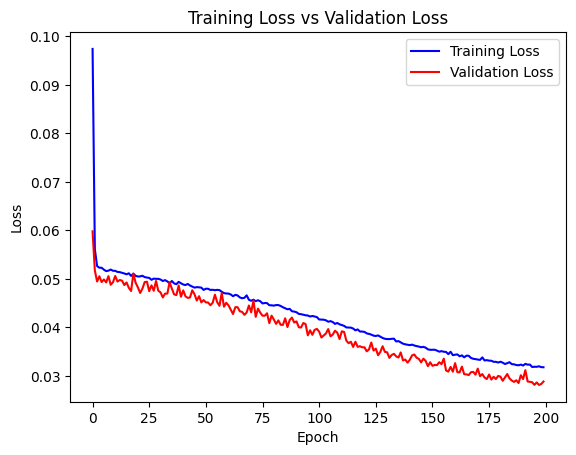

In [21]:
sns.lineplot(data=graph_df, x='Epoch', y='Training Loss', label='Training Loss', color='blue')
sns.lineplot(data=graph_df, x='Epoch', y='Validation Loss', label='Validation Loss', color='red')

# Add a title and labels for clarity
plt.title('Training Loss vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Show the legend
plt.legend()

# Display the plot
plt.show()

In [27]:
# Example normalization constants (replace with actual values used for normalization)
target_min = min_value
target_max = max_value

# Function to denormalize predictions and targets
def denormalize(tensor, min_value, max_value):
    return tensor * (max_value - min_value) + min_value

# Evaluation loop with denormalization of predictions and targets
with torch.no_grad():
    running_val_loss = 0.0
    denormalized_errors = []

    validation_loader_tqdm = tqdm(test_dataloader, desc=f"Epoch {epoch+1}/{EPOCHS} - Validation")
    for vbatch_idx, (vfeatures, vtarget) in enumerate(validation_loader_tqdm):
        voutput = model(vfeatures)
        vloss = loss_fn(voutput, vtarget.unsqueeze(1))
        running_val_loss += vloss.item()

        # Denormalize predictions and targets for error calculation in the original scale
        denormalized_output = denormalize(voutput, target_min, target_max)
        denormalized_target = denormalize(vtarget.unsqueeze(1), target_min, target_max)

        # Calculate denormalized error (e.g., Mean Absolute Error)
        denormalized_error = torch.abs(denormalized_output - denormalized_target).mean().item()
        denormalized_errors.append(denormalized_error)

    avg_val_loss = running_val_loss / len(test_dataloader)
    avg_denormalized_error = sum(denormalized_errors) / len(denormalized_errors)
    validation_loss.append(avg_val_loss)

    print(f"Epoch {epoch+1} - Validation Loss: {avg_val_loss:.4f}")
    print(f"Epoch {epoch+1} - Denormalized Error (MAE): {avg_denormalized_error:.4f}")

Epoch 200/200 - Validation: 100%|██████████| 10/10 [00:00<00:00, 319.95it/s]

Epoch 200 - Validation Loss: 0.0255
Epoch 200 - Denormalized Error (MAE): 58249.5605
